# Path finding

# Path finding with XAI

Segmentation model loaded successfully.
YOLO model loaded successfully.
Faster R-CNN model loaded successfully.
Image loaded: s.png, shape: (375, 1242, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

Generating Grad-CAM explanations for road segmentation...


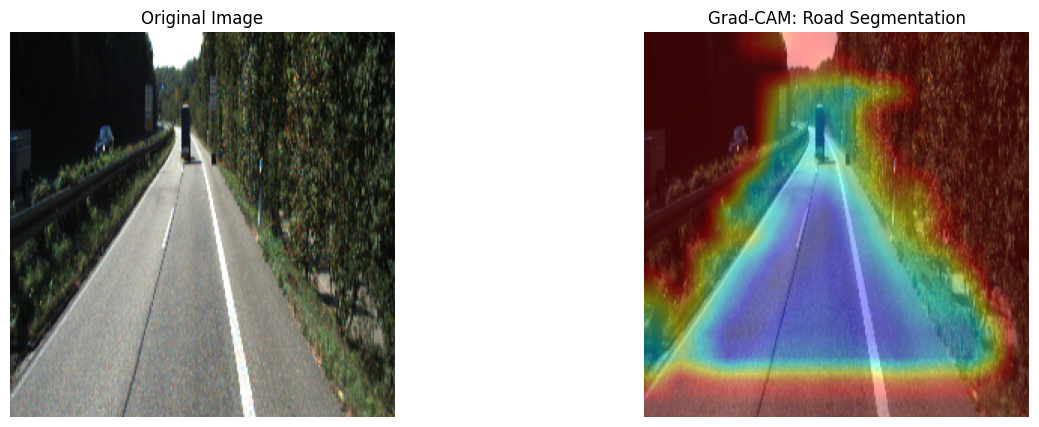


image 1/1 C:\Users\91798\Projects\CV\s.png: 224x640 1 Car, 1 Truck, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)


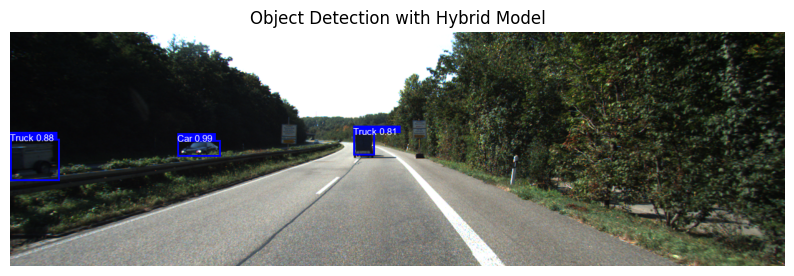


Generating SHAP explanations for all detections...
Processing detection 1/3: Car
SHAP values computed successfully for Car.
Processing detection 2/3: Truck
SHAP values computed successfully for Truck.
Processing detection 3/3: Truck
SHAP values computed successfully for Truck.


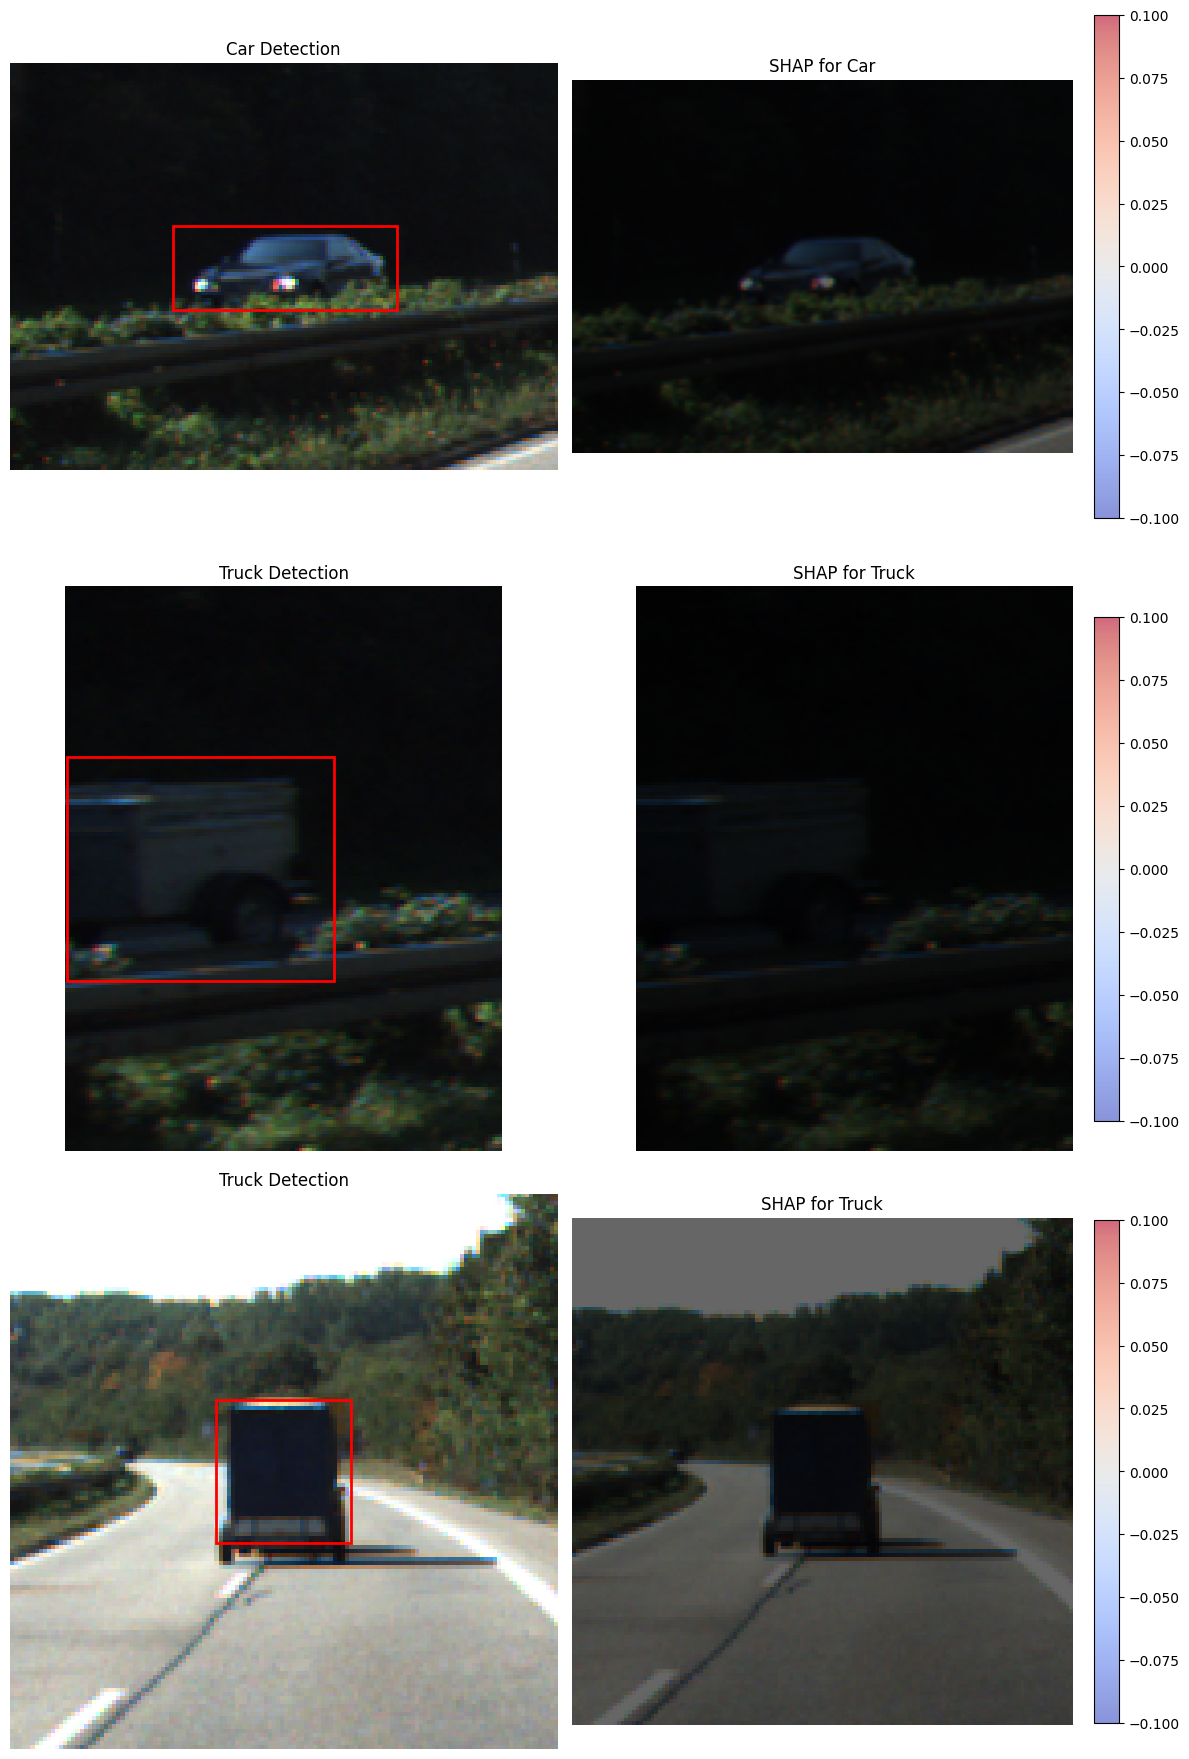

Start point not on road. Searching for nearest road pixel...
Adjusted start to (598, 351)
Attempt 1 with vehicle_width=20
No path found on attempt 1. Reducing vehicle width...
Attempt 2 with vehicle_width=10
No path found on attempt 2. Reducing vehicle width...
Attempt 3 with vehicle_width=5
No path found on attempt 3. Reducing vehicle width...
Attempt 4 with vehicle_width=2
Path found on attempt 4!
Smooth path computed and drawn successfully with A*.


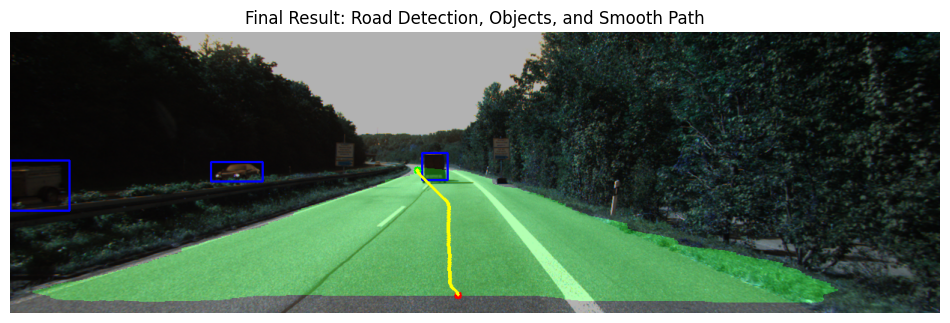

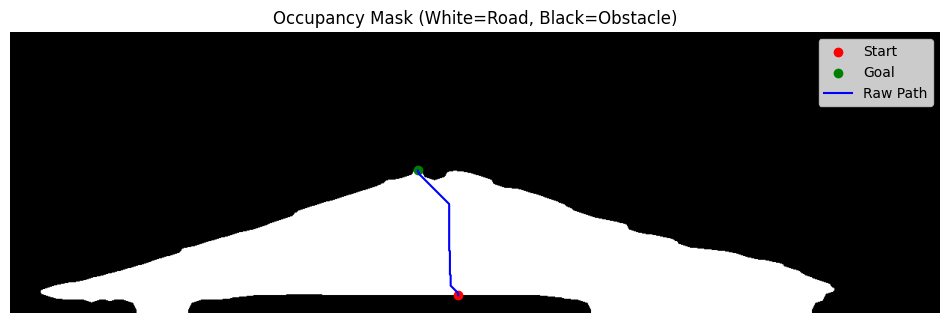

Processing completed successfully.


In [10]:
import cv2
import numpy as np
import torch
import tensorflow as tf
import shap
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, TwoMLPHead
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import MultiScaleRoIAlign
from ultralytics import YOLO
from collections import defaultdict
from torchvision.models.resnet import ResNet50_Weights
import heapq
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEGMENTATION_MODEL_PATH = 'hybrid_seg_model_final.h5'
YOLO_MODEL_PATH = 'trained_yolov10.pt'
FRCNN_MODEL_PATH = 'trained_faster_rcnn.pth'
CLASS_NAMES_SEG = ['traffic light', 'sidewalk', 'building', 'sky', 'fence', 'pole', 
                   'road', 'traffic sign', 'vegetation', 'terrain', 
                   'wall', 'person', 'car']
CLASS_NAMES_DET = ['Van', 'Car', 'Pedestrian', 'Truck', 'Tram', 
                   'Cyclist', 'Person_sitting', 'Misc', 'DontCare']
ROAD_CLASS_INDEX = CLASS_NAMES_SEG.index('road')
SKY_CLASS_INDEX = CLASS_NAMES_SEG.index('sky')

# A* Helper Functions
def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def a_star_search(occupancy_mask, start, goal):
    height, width = occupancy_mask.shape
    start = (start[0], start[1])
    goal = (goal[0], goal[1])
    
    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: euclidean_distance(start, goal)}
    
    while open_list:
        current = heapq.heappop(open_list)[1]
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < width and 0 <= neighbor[1] < height:
                if occupancy_mask[neighbor[1], neighbor[0]] == 0:
                    continue  # Skip obstacles
                tentative_g = g_score[current] + (1 if dx == 0 or dy == 0 else 1.414)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + euclidean_distance(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))
    
    return None  # No path found

def find_goal_road_segment(occupancy_mask, height, width, min_segment_width=10):
    # Search top 100 pixels for a road segment
    for y in range(0, min(100, height)):
        road_pixels = np.where(occupancy_mask[y, :])[0]
        if len(road_pixels) == 0:
            continue
        segments = []
        start = road_pixels[0]
        prev = start
        current_segment = [start]
        for x in road_pixels[1:]:
            if x == prev + 1:
                current_segment.append(x)
            else:
                segments.append(current_segment)
                current_segment = [x]
            prev = x
        if current_segment:
            segments.append(current_segment)
        valid_segments = [seg for seg in segments if len(seg) >= min_segment_width]
        if valid_segments:
            widest_segment = max(valid_segments, key=len)
            end_x = int(np.mean(widest_segment))
            end_y = y
            return end_x, end_y
    # Fallback: Search entire image
    for y in range(0, height):
        road_pixels = np.where(occupancy_mask[y, :])[0]
        if len(road_pixels) == 0:
            continue
        segments = []
        start = road_pixels[0]
        prev = start
        current_segment = [start]
        for x in road_pixels[1:]:
            if x == prev + 1:
                current_segment.append(x)
            else:
                segments.append(current_segment)
                current_segment = [x]
            prev = x
        if current_segment:
            segments.append(current_segment)
        valid_segments = [seg for seg in segments if len(seg) >= min_segment_width]
        if valid_segments:
            widest_segment = max(valid_segments, key=len)
            end_x = int(np.mean(widest_segment))
            end_y = y
            return end_x, end_y
    print("No valid goal segment found! Using center top.")
    return width // 2, 0

def smooth_path(path, occupancy_mask, num_points=200):
    if not path or len(path) < 2:
        return path
    x = np.array([p[0] for p in path])
    y = np.array([p[1] for p in path])
    
    # Parameterize by cumulative distance for better spline fitting
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    distances = np.insert(distances, 0, 0)
    t = np.cumsum(distances)
    t = t / t[-1] if t[-1] > 0 else np.linspace(0, 1, len(t))
    
    # Fit cubic splines
    cs_x = CubicSpline(t, x)
    cs_y = CubicSpline(t, y)
    
    # Generate more points
    t_smooth = np.linspace(0, 1, num_points)
    smooth_x = cs_x(t_smooth)
    smooth_y = cs_y(t_smooth)
    
    # Apply Savitzky-Golay filter for additional smoothing
    window_length = min(21, num_points // 2 * 2 + 1)  # Must be odd
    smooth_x = savgol_filter(smooth_x, window_length, 3)
    smooth_y = savgol_filter(smooth_y, window_length, 3)
    
    # Clip points to image boundaries
    height, width = occupancy_mask.shape
    smooth_x = np.clip(smooth_x, 0, width - 1)
    smooth_y = np.clip(smooth_y, 0, height - 1)
    
    # Ensure points stay on road (optional: adjust off-road points)
    smooth_points = []
    for sx, sy in zip(smooth_x, smooth_y):
        x_int, y_int = int(sx), int(sy)
        if 0 <= y_int < height and 0 <= x_int < width:
            if occupancy_mask[y_int, x_int] == 1:  # On road
                smooth_points.append((x_int, y_int))
            else:
                # Find nearest road pixel within small radius
                for r in range(1, 10):
                    for dx in range(-r, r+1):
                        for dy in range(-r, r+1):
                            nx, ny = x_int + dx, y_int + dy
                            if 0 <= nx < width and 0 <= ny < height and occupancy_mask[ny, nx] == 1:
                                smooth_points.append((nx, ny))
                                break
                        else:
                            continue
                        break
                    else:
                        continue
                    break
                else:
                    smooth_points.append((x_int, y_int))  # Keep original if no road found
        else:
            smooth_points.append((x_int, y_int))
    
    return smooth_points

# XAI Components
class ShapExplainer:
    def __init__(self, model, class_names, target_class):
        self.model = model
        self.class_names = class_names
        self.target_class = target_class
        self.target_index = class_names.index(target_class)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict(self, imgs):
        if isinstance(imgs, np.ndarray):
            if imgs.ndim == 3:
                imgs = [Image.fromarray(imgs)]
            else:
                imgs = [Image.fromarray(img) for img in imgs]
        inputs = torch.stack([self.transform(img) for img in imgs]).to(next(self.model.parameters()).device)
        with torch.no_grad():
            outputs = self.model(inputs)
        scores = []
        for output in outputs:
            target_scores = [score.item() for box, score, label in zip(output['boxes'], output['scores'], output['labels'])
                             if label - 1 == self.target_index]
            scores.append(max(target_scores) if target_scores else 0)
        return np.array(scores).reshape(-1, 1)
    
    def explain(self, image_path, n_samples=50):
        img = Image.open(image_path).convert("RGB")
        img_np = np.array(img)
        masker = shap.maskers.Image("blur(128,128)", img_np.shape)
        explainer = shap.Explainer(self.predict, masker, output_names=[self.target_class])
        try:
            shap_values = explainer(
                np.expand_dims(img_np, 0),
                max_evals=n_samples,
                batch_size=8,
                outputs=shap.Explanation.argsort.flip[:1]
            )
            print(f"SHAP values computed successfully for {self.target_class}.")
            return img_np, shap_values
        except Exception as e:
            print(f"SHAP explanation failed for {self.target_class}: {e}")
            return img_np, None

def crop_around_box(image, box, padding=50):
    x1, y1, x2, y2 = map(int, box)
    h, w = image.shape[:2]
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(w, x2 + padding)
    y2 = min(h, y2 + padding)
    return image[y1:y2, x1:x2], (x1, y1, x2, y2)

def plot_shap_explanations_all(image, detections, shap_values_list, class_names):
    num_detections = len(detections)
    if num_detections == 0:
        return
    
    fig, axes = plt.subplots(num_detections, 2, figsize=(12, 6 * num_detections))
    if num_detections == 1:
        axes = [axes]
    
    for i, (detection, shap_values) in enumerate(zip(detections, shap_values_list)):
        target_class = class_names[int(detection[5])]
        box = detection[:4]
        
        cropped_img, (x1, y1, x2, y2) = crop_around_box(image, box)
        if shap_values is not None and hasattr(shap_values, 'values') and len(shap_values.values) > 0:
            shap_vals = shap_values.values[0]
            heatmap = np.sum(shap_vals, axis=-1)
            cropped_heatmap, _ = crop_around_box(heatmap, box)
            max_val = np.max(np.abs(shap_vals))
        else:
            cropped_heatmap = None
        
        ax_img = axes[i][0] if num_detections > 1 else axes[0][0]
        ax_img.imshow(cropped_img)
        rect = patches.Rectangle((int(box[0]) - x1, int(box[1]) - y1), 
                                 int(box[2] - box[0]), int(box[3] - box[1]), 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax_img.add_patch(rect)
        ax_img.set_title(f"{target_class} Detection")
        ax_img.axis('off')
        
        ax_shap = axes[i][1] if num_detections > 1 else axes[0][1]
        ax_shap.imshow(cropped_img)
        if cropped_heatmap is not None:
            im = ax_shap.imshow(cropped_heatmap, cmap='coolwarm', alpha=0.6, vmin=-max_val, vmax=max_val)
            plt.colorbar(im, ax=ax_shap, fraction=0.046, pad=0.04)
            ax_shap.set_title(f"SHAP for {target_class}")
        else:
            ax_shap.text(0.5, 0.5, "No SHAP values", ha='center', va='center', transform=ax_shap.transAxes)
            ax_shap.set_title(f"SHAP Failed for {target_class}")
        ax_shap.axis('off')
    
    plt.tight_layout()
    plt.show()

def setup_gradcam_model(seg_model):
    target_layer = seg_model.get_layer("conv2d_8")
    grad_model = tf.keras.models.Model(
        inputs=[seg_model.input],
        outputs=[target_layer.output, seg_model.output]
    )
    return grad_model

def compute_gradcam(image, model, target_layer, class_idx):
    img_tensor = np.expand_dims(image, axis=0)
    with tf.GradientTape() as tape:
        conv_output, predictions = model(img_tensor)
        loss = tf.reduce_mean(predictions[:, :, :, class_idx])
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = np.mean(conv_output * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

def apply_heatmap(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

def plot_gradcam_results(image, heatmap, predicted_mask, class_names, explain=True):
    if not explain:
        return
    colored_predicted_mask = np.zeros_like(image)
    colored_predicted_mask[predicted_mask == ROAD_CLASS_INDEX] = [0, 255, 0]
    superimposed_img = apply_heatmap(image, heatmap)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.astype(np.uint8))
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM: Road Segmentation")
    plt.axis("off")
    plt.show()

# Main Components
def load_segmentation_model():
    try:
        model = tf.keras.models.load_model(SEGMENTATION_MODEL_PATH)
        print("Segmentation model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading segmentation model: {e}")
        return None

class FasterRCNNScratch(torch.nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNScratch, self).__init__()
        self.backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.IMAGENET1K_V1, trainable_layers=3)
        out_channels = self.backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
        rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])
        rpn_pre_nms_top_n = dict(training=2000, testing=1000)
        rpn_post_nms_top_n = dict(training=2000, testing=1000)
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head, 0.7, 0.3, 256, 0.5,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, 0.7
        )
        box_roi_pool = MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
        resolution = box_roi_pool.output_size[0]
        representation_size = 1024
        box_head = TwoMLPHead(out_channels * resolution ** 2, representation_size)
        box_predictor = FastRCNNPredictor(representation_size, num_classes)
        self.roi_heads = RoIHeads(
            box_roi_pool, box_head, box_predictor, 0.6, 0.4, 512, 0.25, None, 0.5, 0.3, 50
        )
        self.transform = GeneralizedRCNNTransform(800, 1333, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
        return detections

def load_hybrid_model(yolo_model_path, frcnn_model_path, frmodel_class):
    try:
        yolo_model = YOLO(yolo_model_path)
        print("YOLO model loaded successfully.")
        frcnn_model = frmodel_class(num_classes=len(CLASS_NAMES_DET))
        frcnn_model.load_state_dict(torch.load(frcnn_model_path, map_location=DEVICE))
        frcnn_model.eval()
        frcnn_model.to(DEVICE)
        print("Faster R-CNN model loaded successfully.")
        return {'yolo': yolo_model, 'frcnn': frcnn_model}
    except Exception as e:
        print(f"Error loading hybrid model: {e}")
        return None

def calculate_iou(box1, box2):
    x1 = max(float(box1[0]), float(box2[0]))
    y1 = max(float(box1[1]), float(box2[1]))
    x2 = min(float(box1[2]), float(box2[2]))
    y2 = min(float(box1[3]), float(box2[3]))
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (float(box1[2]) - float(box1[0])) * (float(box1[3]) - float(box1[1]))
    box2_area = (float(box2[2]) - float(box2[0])) * (float(box2[3]) - float(box2[1]))
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def improved_nms(detections, iou_threshold=0.5, class_merge_threshold=0.7):
    if not detections or len(detections) == 0:
        return []
    detections = [list(map(float, d)) for d in detections]
    detections = sorted(detections, key=lambda x: -x[4])
    keep = []
    while detections:
        current = detections.pop(0)
        keep.append(current)
        detections = [
            det for det in detections
            if not (calculate_iou(current[:4], det[:4]) > iou_threshold and 
                    (int(current[5]) == int(det[5]) or abs(current[4] - det[4]) < class_merge_threshold))
        ]
    return keep

def refined_detection(image_path, model, class_names, threshold=0.3, iou_thresh=0.5):
    try:
        image = Image.open(image_path).convert("RGB")
        yolo_results = model['yolo'](image_path)
        yolo_detections = yolo_results[0].boxes.data.cpu().numpy()
        transform = transforms.Compose([transforms.ToTensor()])
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            frcnn_outputs = model['frcnn'](image_tensor)
        frcnn_detections = []
        for det in frcnn_outputs:
            boxes = det['boxes'].cpu().numpy()
            scores = det['scores'].cpu().numpy()
            labels = det['labels'].cpu().numpy() - 1
            for box, score, label in zip(boxes, scores, labels):
                if 0 <= label < len(class_names) and score >= threshold:
                    frcnn_detections.append([*box, score, label])
        all_detections = []
        if len(yolo_detections) > 0:
            all_detections.extend(yolo_detections)
        if len(frcnn_detections) > 0:
            all_detections.extend(frcnn_detections)
        final_detections = improved_nms(all_detections, iou_thresh)
        return np.array(final_detections), image
    except Exception as e:
        print(f"Error in refined_detection: {e}")
        return np.array([]), None

def draw_detections(image, detections, class_names):
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except:
        font = ImageFont.load_default()
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        label_name = class_names[int(cls)]
        color = "red" if label_name.lower() == "pedestrian" else "blue"
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        text = f"{label_name} {conf:.2f}"
        text_bbox = font.getbbox(text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        draw.rectangle([x1, y1 - text_height, x1 + text_width + 5, y1], fill=color)
        draw.text((x1, y1 - text_height), text, fill="white", font=font)
    return image_with_boxes

def remove_sky_portion(img, sky_cutoff_ratio=0.3):
    height = img.shape[0]
    cutoff = int(height * sky_cutoff_ratio)
    return img[cutoff:, :, :], cutoff

def refine_road_mask(road_prob_mask, threshold=0.3, percentile=70):
    adaptive_thresh = np.percentile(road_prob_mask, percentile)
    thresh = max(threshold, adaptive_thresh)
    mask = (road_prob_mask > thresh).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 50:
            cv2.drawContours(mask, [cnt], 0, 0, -1)
    return mask

def process_image(image_path, seg_model, det_model, common_threshold=0.3, explain=True):
    try:
        original_image = Image.open(image_path).convert('RGB')
        img_array = np.array(original_image)
        print(f"Image loaded: {image_path}, shape: {img_array.shape}")

        # Road Segmentation
        no_sky_img, cutoff = remove_sky_portion(img_array)
        seg_image = cv2.resize(no_sky_img, (256, 256))
        seg_input = seg_image.astype(np.float32) / 255.0
        seg_input = np.expand_dims(seg_input, axis=0)
        
        grad_model = setup_gradcam_model(seg_model)
        seg_pred = seg_model.predict(seg_input)
        road_prob_mask = seg_pred[0, ..., ROAD_CLASS_INDEX]
        predicted_mask = np.argmax(seg_pred[0], axis=-1)
        
        heatmap = compute_gradcam(seg_input[0], grad_model, None, ROAD_CLASS_INDEX)
        if explain:
            print("\nGenerating Grad-CAM explanations for road segmentation...")
            plot_gradcam_results(seg_image, heatmap, predicted_mask, CLASS_NAMES_SEG, explain)
        
        road_mask = refine_road_mask(road_prob_mask, common_threshold)
        road_overlay = np.zeros_like(img_array)
        no_sky_height = img_array.shape[0] - cutoff
        resized_mask = cv2.resize(road_mask, (img_array.shape[1], no_sky_height))
        road_overlay[cutoff:, :, 1] = resized_mask * 255

        # Object Detection
        final_detections, original_image = refined_detection(image_path, det_model, CLASS_NAMES_DET, common_threshold)
        if len(final_detections) == 0:
            print("No objects detected.")
        
        image_with_boxes = draw_detections(original_image, final_detections, CLASS_NAMES_DET)
        plt.figure(figsize=(10, 10))
        plt.imshow(image_with_boxes)
        plt.title('Object Detection with Hybrid Model')
        plt.axis('off')
        plt.show()

        # SHAP Explanation
        if explain and len(final_detections) > 0:
            print("\nGenerating SHAP explanations for all detections...")
            shap_values_list = []
            for i, detection in enumerate(final_detections):
                target_class = CLASS_NAMES_DET[int(detection[5])]
                print(f"Processing detection {i+1}/{len(final_detections)}: {target_class}")
                explainer = ShapExplainer(det_model['frcnn'], CLASS_NAMES_DET, target_class=target_class)
                img_np, shap_values = explainer.explain(image_path, n_samples=50)
                shap_values_list.append(shap_values)
            plot_shap_explanations_all(img_array, final_detections, shap_values_list, CLASS_NAMES_DET)

        # Path Planning with A*
        occupancy_mask = (road_overlay[:, :, 1] > 0).astype(np.uint8)
        for det in final_detections:
            x1, y1, x2, y2 = map(int, det[:4])
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(occupancy_mask.shape[1], x2)
            y2 = min(occupancy_mask.shape[0], y2)
            occupancy_mask[y1:y2, x1:x2] = 0
        
        height, width = occupancy_mask.shape
        
        # Aggressive connectivity improvement
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        occupancy_mask = cv2.morphologyEx(occupancy_mask, cv2.MORPH_CLOSE, kernel, iterations=4)
        occupancy_mask = cv2.morphologyEx(occupancy_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # Set start point to middle of bottom
        start_x, start_y = width // 2, height - 1
        
        # Adjust start point if not on road
        max_search_radius = max(width, height) // 3
        if occupancy_mask[start_y, start_x] == 0:
            print("Start point not on road. Searching for nearest road pixel...")
            for r in range(1, max_search_radius):
                for dx in range(-r, r+1):
                    for dy in range(-r, r+1):
                        nx, ny = start_x + dx, start_y + dy
                        if 0 <= nx < width and 0 <= ny < height and occupancy_mask[ny, nx] == 1:
                            start_x, start_y = nx, ny
                            print(f"Adjusted start to ({start_x}, {start_y})")
                            break
                    else:
                        continue
                    break
                else:
                    continue
                break
            else:
                print("No valid start point found! Using fallback.")
                start_x, start_y = width // 2, height - 1
        
        # Find goal point
        goal_x, goal_y = find_goal_road_segment(occupancy_mask, height, width, min_segment_width=10)
        
        # Adjust goal point if not on road
        if occupancy_mask[goal_y, goal_x] == 0:
            print("Goal point not on road. Searching for nearest road pixel...")
            for r in range(1, max_search_radius):
                for dx in range(-r, r+1):
                    for dy in range(-r, r+1):
                        nx, ny = goal_x + dx, goal_y + dy
                        if 0 <= nx < width and 0 <= ny < height and occupancy_mask[ny, nx] == 1:
                            goal_x, goal_y = nx, ny
                            print(f"Adjusted goal to ({goal_x}, {goal_y})")
                            break
                    else:
                        continue
                    break
                else:
                    continue
                break
            else:
                print("No valid goal point found! Using fallback.")
                goal_x, goal_y = width // 2, 0
        
        # Try A* with decreasing vehicle width
        path = None
        vehicle_width = max(8, min(20, width // 25))
        for attempt in range(5):
            print(f"Attempt {attempt+1} with vehicle_width={vehicle_width}")
            temp_occupancy_mask = occupancy_mask.copy()
            if vehicle_width > 0:
                r = vehicle_width // 2
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*r + 1, 2*r + 1))
                obstacle_mask = (temp_occupancy_mask == 0).astype(np.uint8)
                dilated_obstacle_mask = cv2.dilate(obstacle_mask, kernel)
                temp_occupancy_mask = 1 - dilated_obstacle_mask
            
            path = a_star_search(temp_occupancy_mask, (start_x, start_y), (goal_x, goal_y))
            if path is not None:
                occupancy_mask = temp_occupancy_mask
                print(f"Path found on attempt {attempt+1}!")
                break
            print(f"No path found on attempt {attempt+1}. Reducing vehicle width...")
            vehicle_width = max(2, vehicle_width // 2)
        
        # Visualization
        combined = cv2.addWeighted(img_array, 0.7, road_overlay, 0.3, 0)
        for det in final_detections:
            x1, y1, x2, y2 = map(int, det[:4])
            color = (0, 0, 255) if CLASS_NAMES_DET[int(det[5])] == "Pedestrian" else (255, 0, 0)
            cv2.rectangle(combined, (x1, y1), (x2, y2), color, 2)
        
        # Always draw start and goal points
        cv2.circle(combined, (start_x, start_y), 5, (0, 0, 255), -1)
        cv2.circle(combined, (goal_x, goal_y), 5, (0, 255, 0), -1)
        
        if path is None:
            print("No path found with A* after all retries!")
        else:
            # Smooth the path
            smooth_path_points = smooth_path(path, occupancy_mask, num_points=200)
            path_array = np.array(smooth_path_points, dtype=np.int32).reshape(-1, 1, 2)
            cv2.polylines(combined, [path_array], isClosed=False, color=(0, 255, 255), thickness=3)
            print("Smooth path computed and drawn successfully with A*.")
        
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        plt.title('Final Result: Road Detection, Objects, and Smooth Path')
        plt.axis('off')
        plt.show()
        
        # Debug: Show occupancy mask
        plt.figure(figsize=(12, 6))
        plt.imshow(occupancy_mask, cmap='gray')
        plt.title('Occupancy Mask (White=Road, Black=Obstacle)')
        plt.scatter([start_x], [start_y], c='red', label='Start')
        plt.scatter([goal_x], [goal_y], c='green', label='Goal')
        if path is not None:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            plt.plot(path_x, path_y, 'b-', label='Raw Path')
        plt.legend()
        plt.axis('off')
        plt.savefig('occupancy_mask.png')
        plt.show()
        
        return combined
    
    except Exception as e:
        print(f"Error in process_image: {e}")
        return None

# Main Execution
if __name__ == "__main__":
    seg_model = load_segmentation_model()
    if seg_model is None:
        print("Failed to load segmentation model. Exiting.")
        exit(1)
    hybrid_model = load_hybrid_model(YOLO_MODEL_PATH, FRCNN_MODEL_PATH, FasterRCNNScratch)
    if hybrid_model is None:
        print("Failed to load hybrid model. Exiting.")
        exit(1)
    
    image_path = "s.png"  # Replace with your actual image path
    result = process_image(image_path, seg_model, hybrid_model, common_threshold=0.3, explain=True)
    if result is not None:
        print("Processing completed successfully.")
    else:
        print("Processing failed.")